## Random Graph Generation Models


## 1. Watts-Strogatz Model
The [small-world experiment by Milgram](https://en.wikipedia.org/wiki/Small-world_experiment) suggests that you are connected to any other person on the globe only by (on average) six-degrees of seperation. Mathematically speaking a small-world graph is a graph where the average distance between two nodes $L$ is proportional to the number of nodes $N$ in the graph, i.e. $L \propto \text{log}(N)$.

This graph property may be examined with the [Watts-Strogatz model (1998)](http://worrydream.com/refs/Watts-CollectiveDynamicsOfSmallWorldNetworks.pdf) as it generates small-world graphs with short average path lengths and with high clustering coefficients.

![](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2F30918/MediaObjects/41586_1998_Article_BF30918_Fig1_HTML.gif?as=webp)
### Algorithm
1. Consider a ring lattice (as in the figure) with $n$ vertices and $k$ edges per vertex
2. Rewire each edge at random with probability $p \in [0,1]$

As a result we can observe that the graph structure changes with p. In fact goes from regular $(p=0)$ to completely disordered $(p=1)$ with increasing $p$ (see figure).



In [113]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [158]:
def Watts_Strogatz(n, k, p=0):
    G = nx.Graph()
    
    for i in range(n):
        for j in range(1,k+1):
            G.add_edge(i, np.mod(i + j, n))
            
    for i in G.edges():
        if np.random.uniform() < p:

            G.remove_edge(i[0],i[1])

            line = np.arange(n)
            G.add_edge(i[0], np.random.choice(line[line!=i[0]]))
    return G


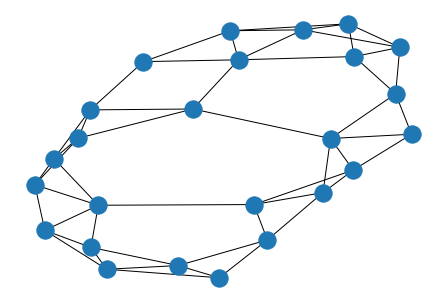

In [133]:
G = Watts_Strogatz(25, 2, p = 0.1)

nx.draw(G)

In [263]:
from networkx.algorithms import transitivity

def WS_clustering(n, k, points=10, iterations=40):
    g0 = Watts_Strogatz(n, k, p=0)
    C0 = average_clustering(g0)
    
    C = np.zeros(points)
    ps = np.logspace(-4, 0, num = points)
    for i in range(points):
        C_ = np.zeros(iterations)
        for j in range(iterations):
            G = Watts_Strogatz(n, k, p = ps[i])
            C_[j] = transitivity(G)
            
        C[i] = np.mean(C_)/C0

    return ps, C

In [264]:
def WS_path_lengths(n, k, points=10, iterations=40):
    g0 = Watts_Strogatz(n, k, p=0)
    L0 = nx.average_shortest_path_length(g0)
    
    L = np.zeros(points)
    ps = np.logspace(-4, 0, num = points)
    for i in range(points):
        L_ = np.zeros(iterations)
        for j in range(iterations):
            G = Watts_Strogatz(n, k, p = ps[i])
            
          
            G.remove_nodes_from(list(nx.isolates(G)))
            
            L_[j] = nx.average_shortest_path_length(G)
            
        L[i] = np.mean(L_)/L0

    return ps, L

In [344]:
ps, C = WS_clustering(250, 4)
ps, L = WS_path_lengths(250, 4)

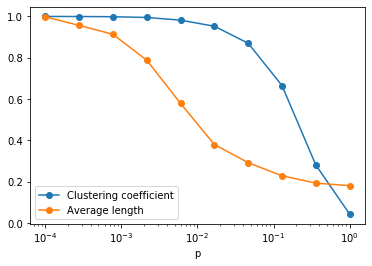

In [345]:
plt.semilogx(ps, C, 'o-', label='Clustering coefficient')
plt.semilogx(ps, L, 'o-', label='Average length')
plt.xlabel('p')
plt.legend()

## 2. Barabási-Albert Model
A scale-free network is a network with a power-law degree distribution $p(k) \propto k^{-\gamma}$. This implies that  there exist a few nodes in a scale-free graph that have an exeptionally higher degree than the average nodes in that graph. These nodes are called hubs.

There are several real-world networks which are (approximately) scale-free, including some social networks, like the the citation graph of scientifc publications and several computer networks, like the linkage graph of Wikipedia.

The Barabási-Albert model uses preferential attachment ("the rich get richer") to generate random scale-free graphs. It was proposed by [Barabasi & Albert in 2002](https://arxiv.org/pdf/cond-mat/0106096.pdf). 
### Algorithm
Start with $m_0$ initial nodes and iterate over $t_{max}$ timesteps. The algorithm includes the following two procedures per time step.
1. Growth: Add one node to the graph at every timestep and connect it to $m \leq m_0$ existing nodes in the graph.
2. Preferential Attachment: When connecting new nodes to other nodes, assume that the probability of connecting the new nodes to an existing node $i$ is proportial to the degree of node $i$, such that 
$p_i = \frac{k_i}{\sum_j k_j}$ where $k_i$ is the degree of node $i$. 


In [247]:

def barabasi_albert(m0, m, t):
    
    if m > m0:
        print("Cant add m edges to m0 nodes. m <= m0 must be fulfilled.")
        return

    G = nx.Graph()
    
    for i in range(m0):
        line = np.arange(m0)
        G.add_edge(i, np.random.choice(line[line!=i]))

    for i in range(t):
        
        p_norm = np.sum(np.array(G.degree())[:,1])
        

        p = np.array(G.degree())[:,1] / p_norm

        G.add_node(m0 + 1 + i)
\
        nodes_to_connect = np.random.choice(G.number_of_nodes()-1, m, p=p)
        
        for j in nodes_to_connect:
            G.add_edge(m0 + 1 + i, j)
         
            
    return G

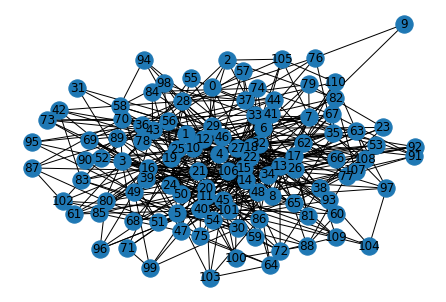

In [245]:
G = barabasi_albert(10,5,100)

nx.draw(G, with_labels=True)

/home/lectures/.conda/envs/lectures/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in power
  


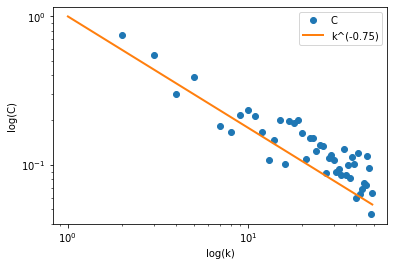

In [276]:
S = 50
C = np.zeros(S)
for i in range(S):
    C[i] = transitivity(barabasi_albert(2,2,i))


plt.loglog(np.linspace(0,S-1,S), C, 'o', label = 'C')
plt.loglog(np.linspace(0,S-1,S), np.linspace(0,S-1,S)**(-.75), linewidth=2, label="k^(-0.75)")
plt.xlabel('log(k)'); plt.ylabel('log(C)')
plt.legend()

In [340]:

def BA_degree_distribution(m, m0, bins = 100, repetitions=100, t_end=100):

    results = np.zeros(bins)

    for i in range(repetitions):
        
        G = barabasi_albert(2,2,t_end)

        t_results, egdes = np.histogram(np.array(G.degree())[:,1], bins=bins, range=[m,t_end], density = True)

        results += t_results
    
    return results/repetitions


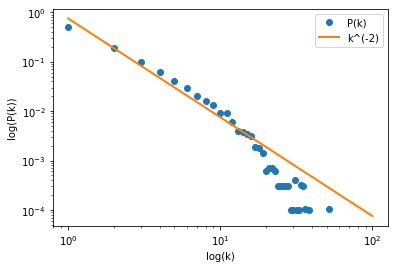

In [343]:
P = BA_degree_distribution(2,2, repetitions=100, t_end=100);

plt.loglog(np.linspace(1,100,100), P, 'o', label="P(k)")
plt.plot(np.linspace(1,100,100), 3/4*np.linspace(1,100,100)**(-2), linewidth=2, label="k^(-2)")
plt.xlabel('log(k)'); plt.ylabel('log(P(k))')
plt.legend()